**Imports**

In [20]:
# Import required libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50, ResNet152, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

**Dataset Loading and Preprocessing**

In [22]:
# Dataset Paths
real_path = 'Dataset/real_and_fake_face/training_real'
fake_path = 'Dataset/real_and_fake_face/training_fake'

In [23]:
# Load dataset and preprocess
def load_image_paths_labels(folder_path, label):
    image_paths, labels = [], []
    for file in os.listdir(folder_path):
        if file.endswith(('.jpg', '.png')):  # Adjust extensions as needed
            image_paths.append(os.path.join(folder_path, file))
            labels.append(label)
    return image_paths, labels


real_paths, real_labels = load_image_paths_labels(real_path, 1)
fake_paths, fake_labels = load_image_paths_labels(fake_path, 0)

image_paths = real_paths + fake_paths
labels = real_labels + fake_labels

df = pd.DataFrame({'Paths': image_paths, 'Real': labels})

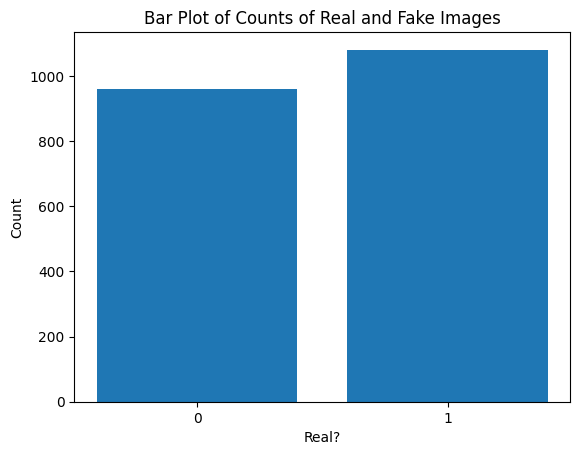

In [24]:
# Bar Plot for Data Distribution
plt.bar(df['Real'].value_counts().index, df['Real'].value_counts().values)
plt.xlabel('Real?')
plt.ylabel('Count')
plt.title('Bar Plot of Counts of Real and Fake Images')
plt.xticks([0, 1])
plt.show()

In [25]:
# Preprocess Images
def preprocess_image(path, target_size=(224, 224), color_mode='rgb'):
    img = load_img(path, target_size=target_size, color_mode=color_mode)
    img_array = img_to_array(img)
    return preprocess_input(img_array)

df['image'] = df['Paths'].apply(preprocess_image)

**Test and Training Data Split**

In [27]:
# Split Dataset
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['Real'], random_state=123)
X_train = np.stack(train_df['image'].values)
y_train = train_df['Real'].values
X_test = np.stack(test_df['image'].values)
y_test = test_df['Real'].values

**Reusable Evaluation Functions**

In [29]:
# Evaluation Function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred_binary)
    TN, FP, FN, TP = cm.ravel()

    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred_binary),
        "Precision": precision_score(y_test, y_pred_binary),
        "Recall": recall_score(y_test, y_pred_binary),
        "F1-Score": f1_score(y_test, y_pred_binary),
        "True Positive Rate": TP / (TP + FN),
        "False Positive Rate": FP / (FP + TN),
        "True Negative Rate": TN / (TN + FP),
        "False Negative Rate": FN / (FN + TP),
        "Confusion Matrix": cm
    }
    return metrics

In [30]:
# Visualization Function
def plot_metrics(metrics):
    cm = metrics["Confusion Matrix"]
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1-Score: {metrics['F1-Score']:.4f}")


**Model Training and Evaluation**

ResNet50

In [33]:
# ResNet50 Model
def resnet50_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [34]:
model_resnet50 = resnet50_model()
model_resnet50.summary()

start_time = time.time()

# Train ResNet50
history = model_resnet50.fit(X_train, y_train, epochs=10, batch_size=20, validation_data=(X_test, y_test))

end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time} seconds")


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

20/20 [==============================] - 2s 72ms/step


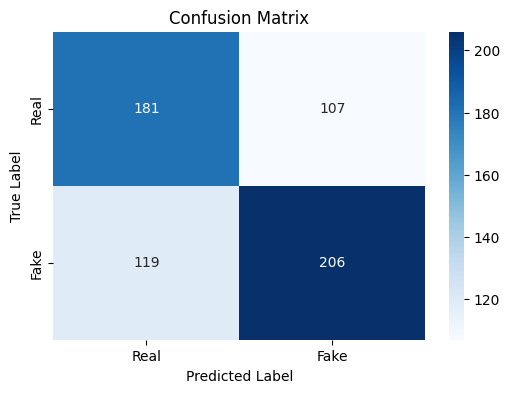

Accuracy: 0.6313
Precision: 0.6581
Recall: 0.6338
F1-Score: 0.6458


In [35]:
# Evaluate ResNet50
resnet50_metrics = evaluate_model(model_resnet50, X_test, y_test)
plot_metrics(resnet50_metrics)


EfficientNet-B0

In [52]:
# EfficientNet-B0 Model
def efficientnet_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_efficientnet = efficientnet_model()
model_efficientnet.summary()

start_time = time.time()

# Train EfficientNet-B0
historyB0 = model_efficientnet.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_test, y_test))

end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time} seconds")


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

20/20 [==============================] - 2s 40ms/step


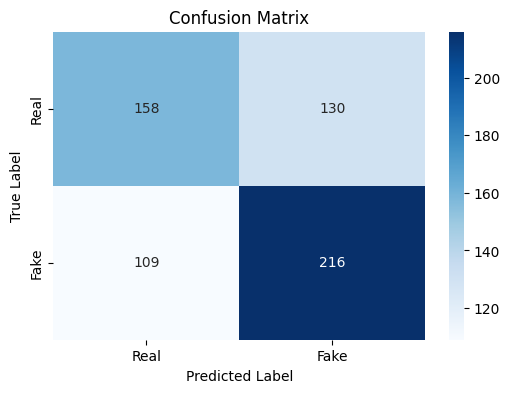

Accuracy: 0.6101
Precision: 0.6243
Recall: 0.6646
F1-Score: 0.6438


In [53]:
# Evaluate EfficientNet-B0
efficientnet_metrics = evaluate_model(model_efficientnet, X_test, y_test)
plot_metrics(efficientnet_metrics)
